In [1]:
import os
for dirname, _, filenames in os.walk('/kaggle/input/btcusd'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
import plotly.express as px
from itertools import product
import warnings
import statsmodels.api as sm
plt.style.use('seaborn-v0_8-darkgrid')

/kaggle/input/btcusd/btcusd_1-min_data.csv


In [2]:
bitstamp = pd.read_csv("/kaggle/input/btcusd/btcusd_1-min_data.csv")
bitstamp.head()
bitstamp.info()
print('Dataset Shape: ',  bitstamp.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7142139 entries, 0 to 7142138
Data columns (total 6 columns):
 #   Column     Dtype  
---  ------     -----  
 0   Timestamp  float64
 1   Open       float64
 2   High       float64
 3   Low        float64
 4   Close      float64
 5   Volume     float64
dtypes: float64(6)
memory usage: 326.9 MB
Dataset Shape:  (7142139, 6)


In [3]:
bitstamp['Timestamp'] = pd.to_datetime(bitstamp['Timestamp'], unit='s')
bitstamp.set_index("Timestamp", inplace=True)

In [4]:
missing_values = bitstamp.isnull().sum()
missing_per = (missing_values/bitstamp.shape[0])*100
missing_table = pd.concat([missing_values,missing_per], axis=1, ignore_index=True) 
missing_table.rename(columns={0:'Total Missing Values',1:'Missing %'}, inplace=True)
missing_table

,Total Missing Values,Missing %
Open,0,0.0
High,0,0.0
Low,0,0.0
Close,0,0.0
Volume,0,0.0


Number of missing timestamps: 1160
First 10 missing timestamps：
DatetimeIndex(['2025-03-15 00:01:00', '2025-03-15 00:02:00',
               '2025-03-15 00:03:00', '2025-03-15 00:04:00',
               '2025-03-15 00:05:00', '2025-03-15 00:06:00',
               '2025-03-15 00:07:00', '2025-03-15 00:08:00',
               '2025-03-15 00:09:00', '2025-03-15 00:10:00'],
              dtype='datetime64[ns]', freq='min')


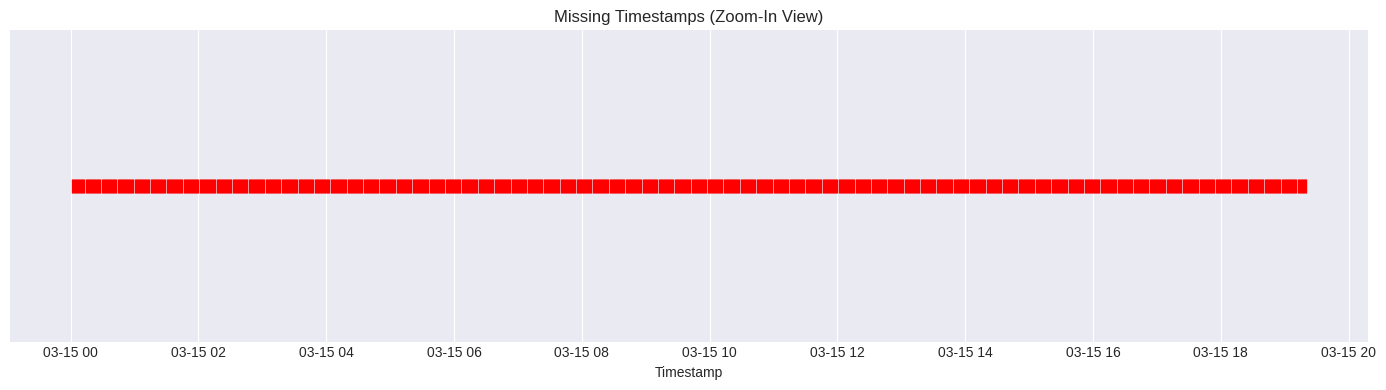

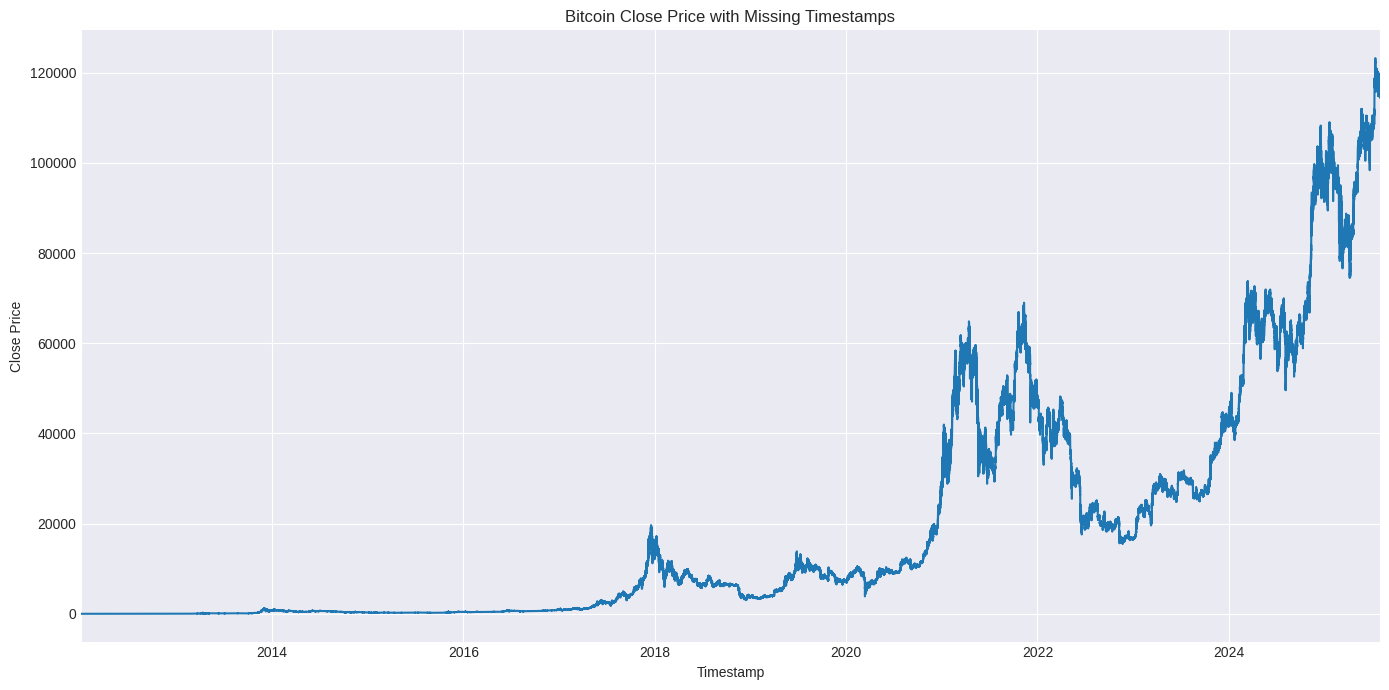

Number of missing timestamps after filling: 0


In [5]:
# Check for missing timestamps (gaps in the datetime index)
full_range = pd.date_range(start=bitstamp.index.min(), end=bitstamp.index.max(), freq='1min')
missing_timestamps = full_range.difference(bitstamp.index)
print("Number of missing timestamps:", len(missing_timestamps))
if len(missing_timestamps) > 0:
    print("First 10 missing timestamps：")
    print(missing_timestamps[:10])

    # Visualize missing timestamps
    missing_df = pd.DataFrame(index=missing_timestamps)
    missing_df['Missing'] = 1
    plt.figure(figsize=(14, 4))
    plt.plot(missing_df.index, missing_df['Missing'], '|', color='red', markersize=10)
    plt.title("Missing Timestamps (Zoom-In View)")
    plt.xlabel("Timestamp")
    plt.yticks([])
    plt.tight_layout()
    plt.show()
else:
    print("✅ No missing timestamps found")

# Fill in missing timestamps using reindex
bitstamp_full = bitstamp.reindex(full_range)

# Plot Close price with missing timestamps (gaps will be visible)
plt.figure(figsize=(14, 7))
bitstamp_full['Close'].plot(title="Bitcoin Close Price with Missing Timestamps")
plt.xlabel("Timestamp")
plt.ylabel("Close Price")
plt.tight_layout()
plt.show()

# Forward-fill missing values to smooth the data
bitstamp_filled = bitstamp_full.ffill()

# Verify that no timestamps are missing after filling
final_range = pd.date_range(start=bitstamp_filled.index.min(), end=bitstamp_filled.index.max(), freq='1min')
final_missing = final_range.difference(bitstamp_filled.index)
print("Number of missing timestamps after filling:", len(final_missing))

In [6]:
# Assume bitstamp_filled is the cleaned and forward-filled Bitcoin 1-minute trading data DataFrame
# Make a copy of the data for feature engineering
bitstamp_filled = bitstamp.ffill()
df = bitstamp_filled.copy()

# Sort the DataFrame by time index (ensure chronological order)
df = df.sort_index()

# 1. Feature Engineering: Create lag features, rolling mean and std features (using only past data to avoid data leakage)
df['lag_1'] = df['Close'].shift(1)    # closing price 1 minute ago
df['lag_5'] = df['Close'].shift(5)    # closing price 5 minutes ago
df['lag_15'] = df['Close'].shift(15)  # closing price 15 minutes ago

# Rolling window features (use shift(1) to avoid using current row info)
df['ma_5'] = df['Close'].rolling(window=5).mean().shift(1)    # 5-minute moving average
df['std_5'] = df['Close'].rolling(window=5).std().shift(1)    # 5-minute rolling std dev
df['ma_15'] = df['Close'].rolling(window=15).mean().shift(1)  # 15-minute moving average
df['std_15'] = df['Close'].rolling(window=15).std().shift(1)  # 15-minute rolling std dev
df['ma_60'] = df['Close'].rolling(window=60).mean().shift(1)  # 60-minute (1-hour) moving average
df['std_60'] = df['Close'].rolling(window=60).std().shift(1)  # 60-minute rolling std dev

# Drop rows with NaNs caused by lag/rolling operations
df.dropna(inplace=True)

# 按照时间筛选出训练+验证集和测试集
df_trainval = df.loc['2020-01-01':'2025-01-01'].copy()
df_test = df.loc['2025-01-01':'2026-01-01'].copy()

# 2. Train-test split: split data by time (80% train, 20% validation)
train_size = int(len(df) * 0.8)
df_train = df.iloc[:train_size].copy()
df_valid = df.iloc[train_size:].copy()

# 3. Define feature list used for modeling (exclude the target column)
exogenous_features = ['lag_1', 'lag_5', 'lag_15',
                      'ma_5', 'std_5', 'ma_15', 'std_15', 'ma_60', 'std_60']
# 4. Define model input data
X_train, y_train = df_train[exogenous_features], df_train['Close']
X_valid, y_valid = df_valid[exogenous_features], df_valid['Close']
X_test, y_test = df_test[exogenous_features], df_test['Close']

In [7]:
from sklearn import ensemble
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from xgboost import plot_importance, plot_tree
from sklearn.metrics import mean_squared_error, mean_absolute_error
plt.style.use('fivethirtyeight')

from datetime import datetime

In [8]:
reg = xgb.XGBRegressor()

In [9]:
## Hyper Parameter Optimization Grid

params={
 "tree_method"      : ["hist"],      # GPU加速的核心参数
 "device"           : ["cuda"],   # 使用GPU预测
 "objective"        : ["reg:squarederror"],
 "learning_rate"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30],
 "max_depth"        : [1, 3, 4, 5, 6, 7],
 "n_estimators"     : [int(x) for x in np.linspace(start=100, stop=2000, num=10)],
 "min_child_weight" : [int(x) for x in np.arange(3, 15, 1)],
 "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "subsample"        : [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bytree" : [0.5, 0.6, 0.7, 0.8, 0.9, 1],
 "colsample_bylevel": [0.5, 0.6, 0.7, 0.8, 0.9, 1],  
}

In [10]:
model  = RandomizedSearchCV(    
                reg,
                param_distributions=params,
                n_iter=5,
                n_jobs=-1,
                cv=3,
                verbose=2,
)
model.fit(X_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [17:35:46] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [17:36:13] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for boo

RandomizedSearchCV(cv=3,
                   estimator=XGBRegressor(base_score=None, booster=None,
                                          callbacks=None,
                                          colsample_bylevel=None,
                                          colsample_bynode=None,
                                          colsample_bytree=None, device=None,
                                          early_stopping_rounds=None,
                                          enable_categorical=False,
                                          eval_metric=None, feature_types=None,
                                          gamma=None, grow_policy=None,
                                          importance_type=None,
                                          interaction_constraints=None,
                                          learning_rate=...
                                        'gamma': [0.0, 0.1, 0.2, 0.3, 0.4, 0.5,
                                                  0.6, 0.7, 0.8, 0.9, 1],
                                        'learning_rate': [0.05, 0.1, 0.15, 0.2,
                                                          0.25, 0.3],
                                        'max_depth': [1, 3, 4, 5, 6, 7],
                                        'min_child_weight': [3, 4, 5, 6, 7, 8,
                                                             9, 10, 11, 12, 13,
                                                             14],
                                        'n_estimators': [100, 311, 522, 733,
                                                         944, 1155, 1366, 1577,
                                                         1788, 2000],
                                        'objective': ['reg:squarederror'],
                                        'subsample': [0.1, 0.2, 0.3, 0.4, 0.5,
                                                      0.6, 0.7, 0.8, 0.9, 1],
                                        'tree_method': ['hist']},
                   verbose=2)

In [11]:
print(f"Model Best Score : {model.best_score_}")
print(f"Model Best Parameters : {model.best_estimator_.get_params()}")

Model Best Score : 0.535461906137401
Model Best Parameters : {'objective': 'reg:squarederror', 'base_score': None, 'booster': None, 'callbacks': None, 'colsample_bylevel': 0.6, 'colsample_bynode': None, 'colsample_bytree': 1, 'device': 'cuda', 'early_stopping_rounds': None, 'enable_categorical': False, 'eval_metric': None, 'feature_types': None, 'gamma': 0.3, 'grow_policy': None, 'importance_type': None, 'interaction_constraints': None, 'learning_rate': 0.2, 'max_bin': None, 'max_cat_threshold': None, 'max_cat_to_onehot': None, 'max_delta_step': None, 'max_depth': 4, 'max_leaves': None, 'min_child_weight': 13, 'missing': nan, 'monotone_constraints': None, 'multi_strategy': None, 'n_estimators': 2000, 'n_jobs': None, 'num_parallel_tree': None, 'random_state': None, 'reg_alpha': None, 'reg_lambda': None, 'sampling_method': None, 'scale_pos_weight': None, 'subsample': 0.3, 'tree_method': 'hist', 'validate_parameters': None, 'verbosity': None}


In [12]:
model.best_estimator_
# 训练集预测
df_train.loc[:, 'Forecast_XGBoost'] = model.predict(X_train)

# 测试集预测（你已经做过了，确保是这样写的）
df_test.loc[:, 'Forecast_XGBoost'] = model.predict(X_test)

overall_data = pd.concat([df_train, df_valid], sort=False)

/usr/local/lib/python3.11/dist-packages/xgboost/core.py:160: UserWarning: [17:40:20] WARNING: /workspace/src/common/error_msg.cc:58: Falling back to prediction using DMatrix due to mismatched devices. This might lead to higher memory usage and slower performance. XGBoost is running on: cuda:0, while the input data is on: cpu.
Potential solutions:
- Use a data structure that matches the device ordinal in the booster.
- Set the device for booster before call to inplace_predict.

This warning will only be shown once.

  warnings.warn(smsg, UserWarning)


<Axes: xlabel='Timestamp'>

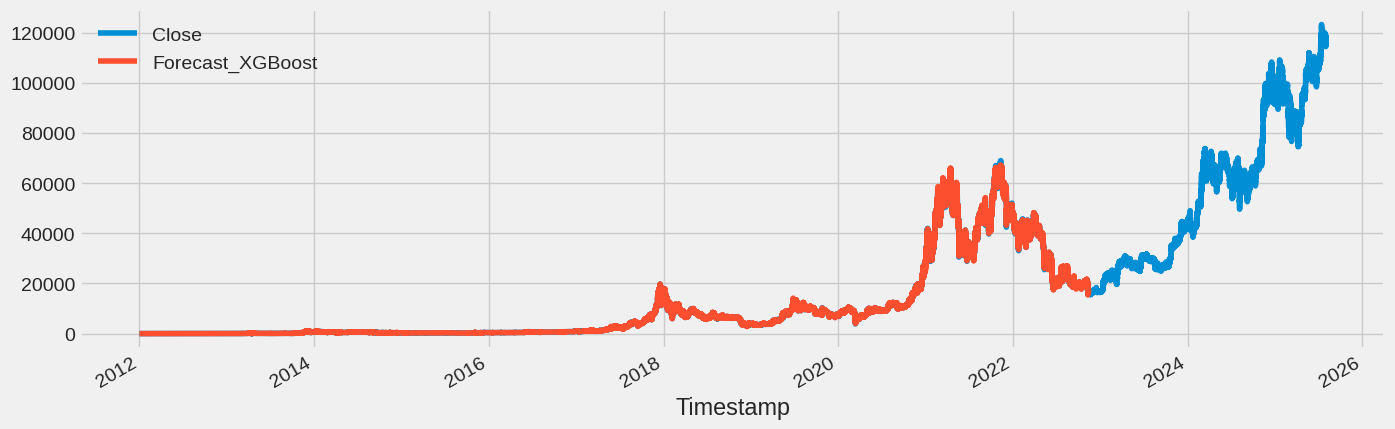

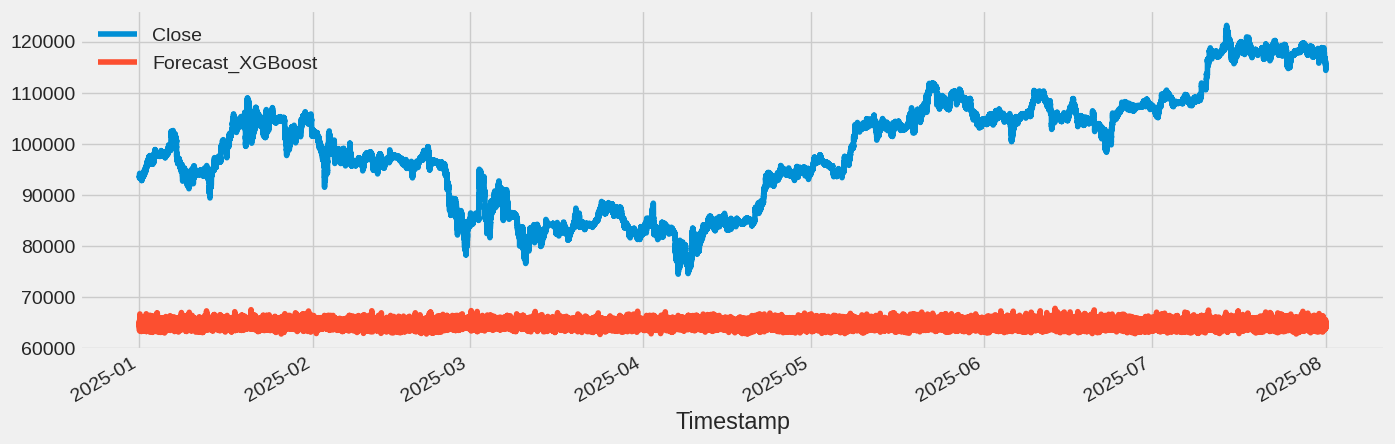

In [13]:
overall_data[['Close','Forecast_XGBoost']].plot(figsize=(15, 5))
df_test[['Close','Forecast_XGBoost']].plot(figsize=(15, 5))

In [14]:
from sklearn.metrics import mean_absolute_error, mean_squared_error,r2_score

In [15]:
train_mae = mean_absolute_error(df_train['Close'], df_train['Forecast_XGBoost'])
train_rmse = np.sqrt(mean_squared_error(df_train['Close'], df_train['Forecast_XGBoost']))
train_r2 = r2_score(df_train['Close'], df_train['Forecast_XGBoost'])

print(f"train MAE : {train_mae}")
print(f"train RMSE : {train_rmse}")
print(f"train R2 : {train_r2}")

train MAE : 56.36812380885909
train RMSE : 157.76677840014932
train R2 : 0.9998913360951827


In [16]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

test_mae = mean_absolute_error(df_test['Close'], df_test['Forecast_XGBoost'])
test_rmse = np.sqrt(mean_squared_error(df_test['Close'], df_test['Forecast_XGBoost']))
test_r2 = r2_score(df_test['Close'], df_test['Forecast_XGBoost'])

print(f"Test MAE  : {test_mae}")
print(f"Test RMSE : {test_rmse}")
print(f"Test R²   : {test_r2}")

Test MAE  : 34259.502998455886
Test RMSE : 35943.64118168122
Test R²   : -9.977152980671443
